In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [425]:
pd.set_option('display.max_rows',300)
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:,.2f}'.format

In [147]:
#Need to merge these two since the gmm cluster file didn't have social engagement score or other features.
#In production, this approach should not be done.  It was necessary because we failed to reset the index on
#the dataset before doing the GMM work and therefore merging on index is not possible.  To fix this
#reset the index on the combined social data before doing any work and rerun tsne/GMM (~24 hours on AWS)
df = pd.read_pickle('sony_music_tsne_gmm_dfCluster.pkl')
df_complete = pd.read_pickle('../Combined_Social_Data_Pickle.pkl')

In [462]:
df.columns

Index(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'age', 'artist_name_x',
       'created_12am-6am', 'created_12pm-6pm', 'created_6am-12pm',
       'created_6pm-12am', 'description_length', 'hashtag_count',
       'last_30_days', 'last_7_days', 'time_since_last_post', 'type_link',
       'type_photo', 'type_text', 'type_video', 'years_active',
       'num_days_to_track_release', 'genre_electronic', 'genre_hip_hop',
       'genre_pop', 'genre_r_and_b', 'genre_rock', 'genre_world_music',
       'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5'],
      dtype='object')

In [148]:
#Only use data from 1/1/16 to 6/1/19
df_complete = df_complete[(df_complete['created']>pd.to_datetime('01-01-2016')) &
                          (df_complete['created']<pd.to_datetime('06-01-2019'))]

In [149]:
df_complete['time_since_last_post'] = pd.to_timedelta(df_complete['time_since_last_post'])
df_complete['time_since_last_post'] = [x.total_seconds() for x in df_complete['time_since_last_post']]

In [150]:
df_complete = df_complete[df_complete['social_engagement_score'].notnull()]

In [151]:
df.shape

(648894, 33)

In [158]:
df.drop_duplicates(subset=['time_since_last_post','artist_name_x', 'description_length',
                                               'hashtag_count','num_days_to_track_release','last_7_days', 'last_30_days',
                                               'Facebook','Instagram','Twitter','Youtube','type_link',
                                               'type_photo','type_text','type_video','created_12am-6am',
                                               'created_12pm-6pm','created_6am-12pm','created_6pm-12am'],inplace=True, keep=False)

In [159]:
df.shape

(645706, 33)

In [160]:
print(645706/648894) #lost posts

0.9950870249994607


In [161]:
df_complete.shape

(675925, 42)

In [179]:
df_total = df_complete.merge(df,how='right',on=['time_since_last_post','artist_name_x', 'description_length',
                                               'hashtag_count','num_days_to_track_release','last_7_days', 'last_30_days',
                                               'Facebook','Instagram','Twitter','Youtube','type_link',
                                               'type_photo','type_text','type_video','created_12am-6am',
                                               'created_12pm-6pm','created_6am-12pm','created_6pm-12am'])

In [180]:
df_total.shape

(648886, 56)

In [181]:
df_total.loc[0]

Facebook                                                                 1
Instagram                                                                0
Twitter                                                                  0
Youtube                                                                  0
age_x                                                               37.000
artist_name_x                                                  AdamLambert
artist_name_y                                                 Adam Lambert
count_of_followers                                             4919284.000
created                                                2016-01-01 14:33:30
created_12am-6am                                                         0
created_12pm-6pm                                                         1
created_6am-12pm                                                         0
created_6pm-12am                                                         0
crowdtangle_score        

In [182]:
df_complete.loc[702]

,Facebook,Instagram,Twitter,Youtube,age,artist_name_x,artist_name_y,count_of_followers,created,created_12am-6am,created_12pm-6pm,created_6am-12pm,created_6pm-12am,crowdtangle_score,description,description_length,facebook,genre_electronic,genre_hip_hop,genre_pop,genre_r_and_b,genre_rock,genre_world_music,hashtag_count,instagram,last_30_days,last_7_days,musicbrainz,social_engagement_score,time_since_last_post,twitter,type_link,type_photo,type_text,type_video,within_month_release,within_week_release,years_active,youtube,social_platform,normalized_social_engagement_score,num_days_to_track_release
702,1,0,0,0,37,AdamLambert,Adam Lambert,4919284.000,2016-01-01 14:33:30,0,1,0,0,9.04,NYE SINGAPORE: Lewdless as usual,32,AdamLambert,0.000,0,1,0,1,0.000,0.000,adamlambert,1.000,1.000,e942594a-91cc-427a-8beb-6815c28e9254,0.010,153999.000,adamlambert,0,1,0,0,0,0,18,Adam Lambert,Facebook,0.654,76
702,0,0,1,0,35,1future,Future,2060303.000,2016-01-13 02:08:12,1,0,0,0,-3.48,Just posted a photo https://www.instagram.com/...,60,FutureOfficial,0.000,1,0,0,0,0.000,0.000,future,70.000,32.000,48262e82-db9f-4a92-b650-dfef979b73ec,0.000,91.000,1future,1,0,0,0,0,0,10,Future,Twitter,-0.216,3


In [183]:
df.loc[702]

,Facebook,Instagram,Twitter,Youtube,age,artist_name_x,created_12am-6am,created_12pm-6pm,created_6am-12pm,created_6pm-12am,description_length,hashtag_count,last_30_days,last_7_days,time_since_last_post,type_link,type_photo,type_text,type_video,years_active,num_days_to_track_release,genre_electronic,genre_hip_hop,genre_pop,genre_r_and_b,genre_rock,genre_world_music,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
702,1,0,0,0,37,AdamLambert,0,1,0,0,32,0.000,1.000,1.000,153999.000,0,1,0,0,18,76,0.000,0,1,0,1,0.000,1,0,0,0,0,0
702,0,0,1,0,35,1future,1,0,0,0,60,0.000,70.000,32.000,91.000,1,0,0,0,10,3,0.000,1,0,0,0,0.000,0,0,0,1,0,0
702,0,0,0,1,34,J. Cole,0,0,1,0,23,0.000,2.000,2.000,19.000,0,0,0,1,12,3,0.000,1,0,0,0,0.000,0,0,1,0,0,0


In [ ]:
df_in.reset_index(inplace=True,drop=True) #necessary since the index numbers weren't starting at zero.

In [191]:
def make_categorical(df_in, dummies, catname):
    '''
    Creates a categorical column in the dataframe (df_in)
    based on a provided list of (dummies) and a (catname) for the new categorical column
    '''
    x = df_in[dummies].stack()
    df_in[catname] = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

In [185]:
df_total.columns

Index(['Facebook', 'Instagram', 'Twitter', 'Youtube', 'age_x', 'artist_name_x',
       'artist_name_y', 'count_of_followers', 'created', 'created_12am-6am',
       'created_12pm-6pm', 'created_6am-12pm', 'created_6pm-12am',
       'crowdtangle_score', 'description', 'description_length', 'facebook',
       'genre_electronic_x', 'genre_hip_hop_x', 'genre_pop_x',
       'genre_r_and_b_x', 'genre_rock_x', 'genre_world_music_x',
       'hashtag_count', 'instagram', 'last_30_days', 'last_7_days',
       'musicbrainz', 'social_engagement_score', 'time_since_last_post',
       'twitter', 'type_link', 'type_photo', 'type_text', 'type_video',
       'within_month_release', 'within_week_release', 'years_active_x',
       'youtube', 'social_platform', 'normalized_social_engagement_score',
       'num_days_to_track_release', 'age_y', 'years_active_y',
       'genre_electronic_y', 'genre_hip_hop_y', 'genre_pop_y',
       'genre_r_and_b_y', 'genre_rock_y', 'genre_world_music_y', 'cluster_0',
       

In [186]:
df_total = df_total[['Facebook', 'Instagram', 'Twitter', 'Youtube', 'age_x', 'artist_name_y',
       'count_of_followers', 'created', 'created_12am-6am',
       'created_12pm-6pm', 'created_6am-12pm', 'created_6pm-12am',
       'crowdtangle_score', 'description', 'description_length', 
       'genre_electronic_x', 'genre_hip_hop_x', 'genre_pop_x',
       'genre_r_and_b_x', 'genre_rock_x', 'genre_world_music_x',
       'hashtag_count', 'last_30_days', 'last_7_days',
       'social_engagement_score', 'time_since_last_post',
       'type_link', 'type_photo', 'type_text', 'type_video',
       'within_month_release', 'within_week_release', 'years_active_x',
       'social_platform', 'normalized_social_engagement_score',
       'num_days_to_track_release','cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5','cluster']]

In [ ]:
def make_categorical(df_in, dummies, catname):
    '''
    Creates a categorical column in the dataframe (df_in)
    based on a provided list of (dummies) and a (catname) for the new categorical column
    '''
    x = df_in[dummies].stack()
    df_in[catname] = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

In [ ]:
#This function reconfigures a singular 'cluster' column from the individual dummy clusters.
# dummies = ['cluster_0','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5']
# x = df_total[dummies].stack()
# df_total.reset_index(inplace=True,drop=True) #necessary since the index numbers weren't starting at zero.
# df_total['cluster'] = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

In [ ]:
make_categorical(df_total,['cluster_0','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5'],'cluster')

In [198]:
make_categorical(df_total,['created_12am-6am',
       'created_12pm-6pm', 'created_6am-12pm', 'created_6pm-12am'],'created_tod')

In [200]:
make_categorical(df_total,['type_link', 'type_photo', 'type_text', 'type_video'],'post_type')

In [201]:
df_total.head(10).T

,0,1,2,3,4,5,6,7,8,9
Facebook,1,1,1,1,1,1,1,1,1,1
Instagram,0,0,0,0,0,0,0,0,0,0
Twitter,0,0,0,0,0,0,0,0,0,0
Youtube,0,0,0,0,0,0,0,0,0,0
age_x,37.000,37.000,37.000,37.000,37.000,37.000,37.000,37.000,37.000,37.000
artist_name_y,Adam Lambert,Adam Lambert,Adam Lambert,Adam Lambert,Adam Lambert,Adam Lambert,Adam Lambert,Adam Lambert,Adam Lambert,Adam Lambert
count_of_followers,4919284.000,4920137.000,4920338.000,4920338.000,4920461.000,4921792.000,4921792.000,4922619.000,4923484.000,4923192.000
created,2016-01-01 14:33:30,2016-01-04 13:04:48,2016-01-06 11:20:55,2016-01-06 16:55:39,2016-01-07 16:24:59,2016-01-11 02:11:07,2016-01-11 16:30:50,2016-01-13 11:32:40,2016-01-15 10:44:22,2016-01-19 09:50:00
created_12am-6am,0,0,0,0,0,1,0,0,0,0
created_12pm-6pm,1,1,0,1,1,0,1,0,0,0


In [175]:
df_total.shape

(648886, 43)

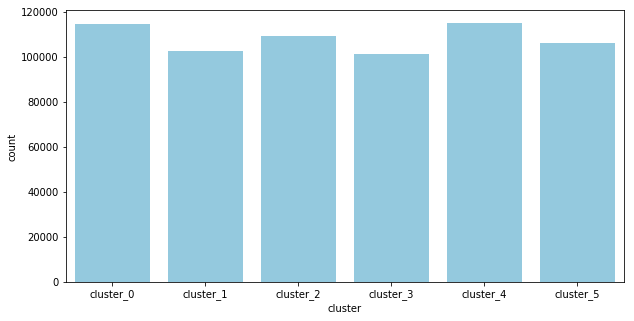

In [329]:
fig = plt.figure(figsize=(10,5))
#df.groupby('cluster').size().plot(kind='bar') #also works
sns.countplot(df_total['cluster'],color='skyblue')
plt.show()

In [177]:
df_total.groupby('cluster').describe().T

cluster                                      cluster_0     cluster_1  \
Facebook                           count    114784.000    102621.000   
                                   mean          0.285         0.165   
                                   std           0.451         0.371   
                                   min           0.000         0.000   
                                   25%           0.000         0.000   
                                   50%           0.000         0.000   
                                   75%           1.000         0.000   
                                   max           1.000         1.000   
Instagram                          count    114784.000    102621.000   
                                   mean          0.268         0.430   
                                   std           0.443         0.495   
                                   min           0.000         0.000   
                                   25%           0.000         0.000   
                                   50%           0.000         0.000   
                                   75%           1.000         1.000   
                                   max           1.000         1.000   
Twitter                            count    114784.000    102621.000   
                                   mean          0.442         0.406   
                                   std           0.497         0.491   
                                   min           0.000         0.000   
                                   25%           0.000         0.000   
                                   50%           0.000         0.000   
                                   75%           1.000         1.000   
                                   max           1.000         1.000   
Youtube                            count    114784.000    102621.000   
                                   mean          0.006         0.000   
                                   std           0.074         0.000   
                                   min           0.000         0.000   
                                   25%           0.000         0.000   
                                   50%           0.000         0.000   
                                   75%           0.000         0.000   
                                   max           1.000         0.000   
age_x                              count    113554.000    102120.000   
                                   mean         38.429        38.205   
                                   std          12.725        11.124   
                                   min          15.000        15.000   
                                   25%          28.000        29.000   
                                   50%          38.000        38.000   
                                   75%          43.000        44.000   
                                   max          78.000        78.000   
count_of_followers                 count    113554.000    102120.000   
                                   mean    9809319.027   9180649.766   
                                   std    15196253.759  15332044.134   
                                   min        2250.000      3747.000   
                                   25%     1511992.500   1414384.500   
                                   50%     3978461.000   3591538.000   
                                   75%    11142193.250   9634079.000   
                                   max   155527214.000 156302337.000   
created_12am-6am                   count    114784.000    102621.000   
                                   mean          0.151         0.202   
                                   std           0.358         0.401   
                                   min           0.000         0.000   
                                   25%           0.000         0.000   
                                   50%           0.000         0.000   
                                   75%  

In [461]:
df_total.groupby(['cluster','social_platform'])['normalized_social_engagement_score'].describe().T

cluster         cluster_0                     cluster_1                      \
social_platform  Facebook Instagram   Twitter  Facebook Instagram   Twitter   
count           32,652.00 30,197.00 50,705.00 16,892.00 43,591.00 41,637.00   
mean                -0.06     -0.24      0.05     -0.01      0.03     -0.06   
std                  0.89      0.87      1.18      0.80      1.09      0.68   
min                 -0.32     -0.80     -0.23     -0.32     -0.80     -0.23   
25%                 -0.29     -0.66     -0.22     -0.30     -0.63     -0.23   
50%                 -0.25     -0.51     -0.19     -0.25     -0.36     -0.21   
75%                 -0.09     -0.19     -0.04     -0.07      0.25     -0.11   
max                 56.36     13.22    133.43     21.61     14.04     51.90   

cluster         cluster_2                     cluster_3                      \
social_platform  Facebook Instagram   Twitter  Facebook Instagram   Twitter   
count           24,822.00 40,780.00 42,459.00 33,199.00 30,330.00 37,226.00   
mean                 0.01     -0.02      0.05      0.10     -0.03      0.06   
std                  1.01      1.05      1.10      1.29      0.92      1.04   
min                 -0.32     -0.80     -0.23     -0.32     -0.80     -0.23   
25%                 -0.30     -0.65     -0.23     -0.29     -0.61     -0.22   
50%                 -0.25     -0.40     -0.21     -0.23     -0.38     -0.20   
75%                 -0.10      0.18     -0.08     -0.02      0.17     -0.07   
max                 36.92     53.73    126.00     71.80     12.16     47.45   

cluster         cluster_4                     cluster_5                      
social_platform  Facebook Instagram   Twitter  Facebook Instagram   Twitter  
count           22,787.00 34,485.00 56,821.00 27,488.00 28,424.00 49,464.00  
mean                -0.05      0.10      0.01     -0.00     -0.23      0.01  
std                  0.83      1.02      1.15      1.30      0.81      1.08  
min                 -0.32     -0.80     -0.23     -0.32     -0.80     -0.23  
25%                 -0.30     -0.57     -0.22     -0.30     -0.69     -0.22  
50%                 -0.25     -0.25     -0.20     -0.26     -0.52     -0.20  
75%                 -0.13      0.38     -0.08     -0.12     -0.09     -0.09  
max                 37.05     17.01    138.89     98.30     13.03    113.00

Features to explore a bit more:

 * bar chart Distribution of social_platform (Instagram, Facebook, Twitter, Youtube)
 * histogram Distribution of age, years_active_x
 * histogram Distribution of count_of_followers, perhaps by social_platform
 * bar chart Distribution of created_tod
 * bar chart Distribution of each individual genre, by cluster
 * histogram Distribution of description_length, hashtag_count
 * bar chart Distribution of post_type
 * histogram Distribution of num_days_to_track_release
 * histogram Distribution of time_since_last_post
 * scatter plot correlation of many of these features with social_engagement_score

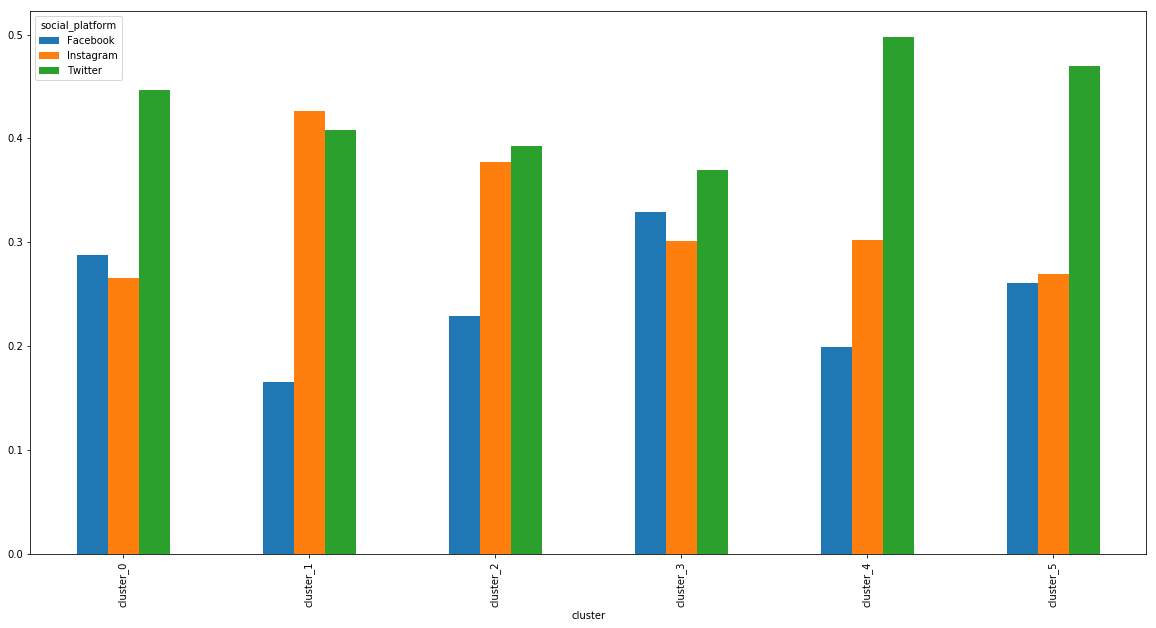

In [303]:
pd.crosstab(df_total['cluster'],df_total['social_platform'], normalize='index').plot(kind='bar', figsize=(20,10))

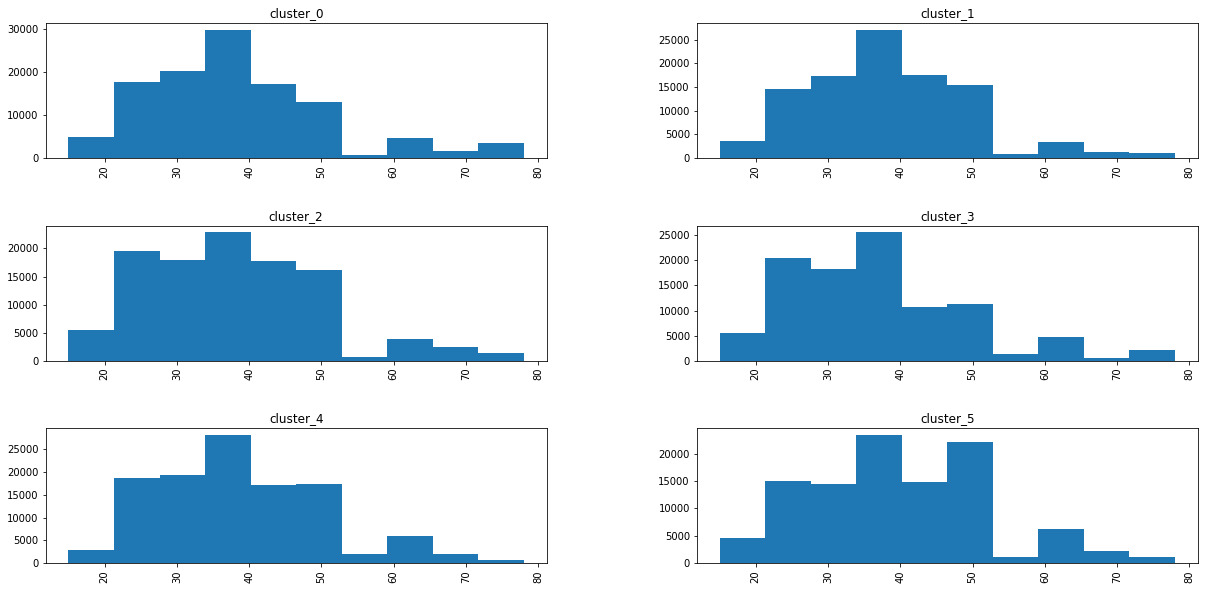

In [345]:
df_total['age_x'].hist(by=df_total['cluster'], figsize=(20,10))
plt.show()

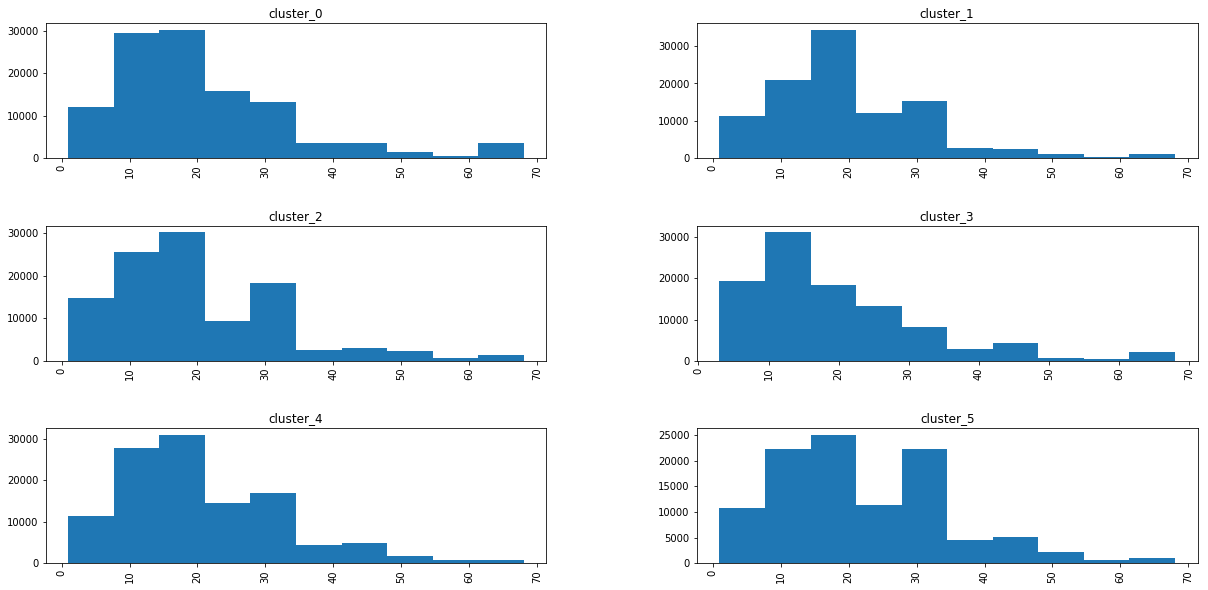

In [346]:
df_total['years_active_x'].hist(by=df_total['cluster'], figsize=(20,10))
plt.show()

In [429]:
df_total.groupby(['cluster','social_platform'])['count_of_followers'].describe()

count          mean           std       min  \
cluster   social_platform                                                   
cluster_0 Facebook        32,652.00 11,840,924.53 14,993,789.72  2,250.00   
          Instagram       30,197.00 13,602,252.73 18,651,484.20 22,620.00   
          Twitter         50,705.00  6,242,191.49 11,885,791.85 41,436.00   
cluster_1 Facebook        16,892.00 11,660,851.50 14,378,940.77  3,747.00   
          Instagram       43,591.00 10,798,459.19 18,265,695.75 22,199.00   
          Twitter         41,637.00  6,480,707.45 11,439,203.82 36,436.00   
cluster_2 Facebook        24,822.00 12,640,740.66 15,341,801.02  1,087.00   
          Instagram       40,780.00 13,322,658.14 22,524,642.21 22,282.00   
          Twitter         42,459.00  6,479,803.71 11,541,906.44 35,887.00   
cluster_3 Facebook        33,199.00 13,598,238.73 18,596,403.28  1,564.00   
          Instagram       30,330.00 13,475,274.54 22,218,342.51 22,744.00   
          Twitter         37,226.00  6,767,575.51 12,876,217.42 35,479.00   
cluster_4 Facebook        22,787.00 13,582,122.65 17,185,787.09  4,402.00   
          Instagram       34,485.00  9,547,990.24 16,095,291.73 23,583.00   
          Twitter         56,821.00  7,469,332.51 12,228,830.98 35,632.00   
cluster_5 Facebook        27,488.00 16,367,523.00 19,061,780.63  1,551.00   
          Instagram       28,424.00  8,879,245.81  9,932,183.65 22,199.00   
          Twitter         49,464.00  6,842,552.27 11,436,155.72 35,479.00   

                                   25%           50%           75%  \
cluster   social_platform                                            
cluster_0 Facebook        1,996,231.00  5,872,749.00 16,666,223.25   
          Instagram       2,529,698.00  6,613,355.00 17,036,543.00   
          Twitter           886,971.00  2,439,883.00  4,762,616.00   
cluster_1 Facebook        1,886,311.50  5,691,397.00 18,119,895.25   
          Instagram       1,497,472.00  4,639,412.00 11,489,868.00   
          Twitter         1,043,102.00  2,856,496.00  4,582,539.00   
cluster_2 Facebook        3,118,593.00  5,712,402.00 15,940,815.00   
          Instagram       1,483,015.50  4,870,074.50 13,787,153.75   
          Twitter           908,325.50  2,900,417.00  5,431,249.50   
cluster_3 Facebook        1,633,288.00  5,522,368.00 18,537,268.50   
          Instagram       1,716,037.50  4,720,023.50 14,269,861.00   
          Twitter           692,379.00  2,460,070.00  5,696,624.50   
cluster_4 Facebook        1,916,023.50  5,699,429.00 18,126,569.00   
          Instagram       1,102,165.00  3,917,384.00 10,680,445.00   
          Twitter         1,139,790.00  3,097,368.00  7,764,316.00   
cluster_5 Facebook        2,412,220.50 10,030,544.50 20,145,648.25   
          Instagram       1,071,265.00  4,785,874.00 13,385,998.00   
          Twitter           909,048.00  3,141,147.00  7,572,930.25   

                                     max  
cluster   social_platform                 
cluster_0 Facebook        104,633,884.00  
          Instagram       155,527,214.00  
          Twitter         106,537,500.00  
cluster_1 Facebook        104,633,884.00  
          Instagram       156,302,337.00  
          Twitter         106,519,675.00  
cluster_2 Facebook        104,633,659.00  
          Instagram       156,391,787.00  
          Twitter         105,671,145.00  
cluster_3 Facebook        104,633,659.00  
          Instagram       156,530,344.00  
          Twitter         106,500,189.00  
cluster_4 Facebook        104,635,502.00  
          Instagram       156,530,344.00  
          Twitter         106,688,197.00  
cluster_5 Facebook        104,639,498.00  
          Instagram       106,746,005.00  
          Twitter         106,688,197.00

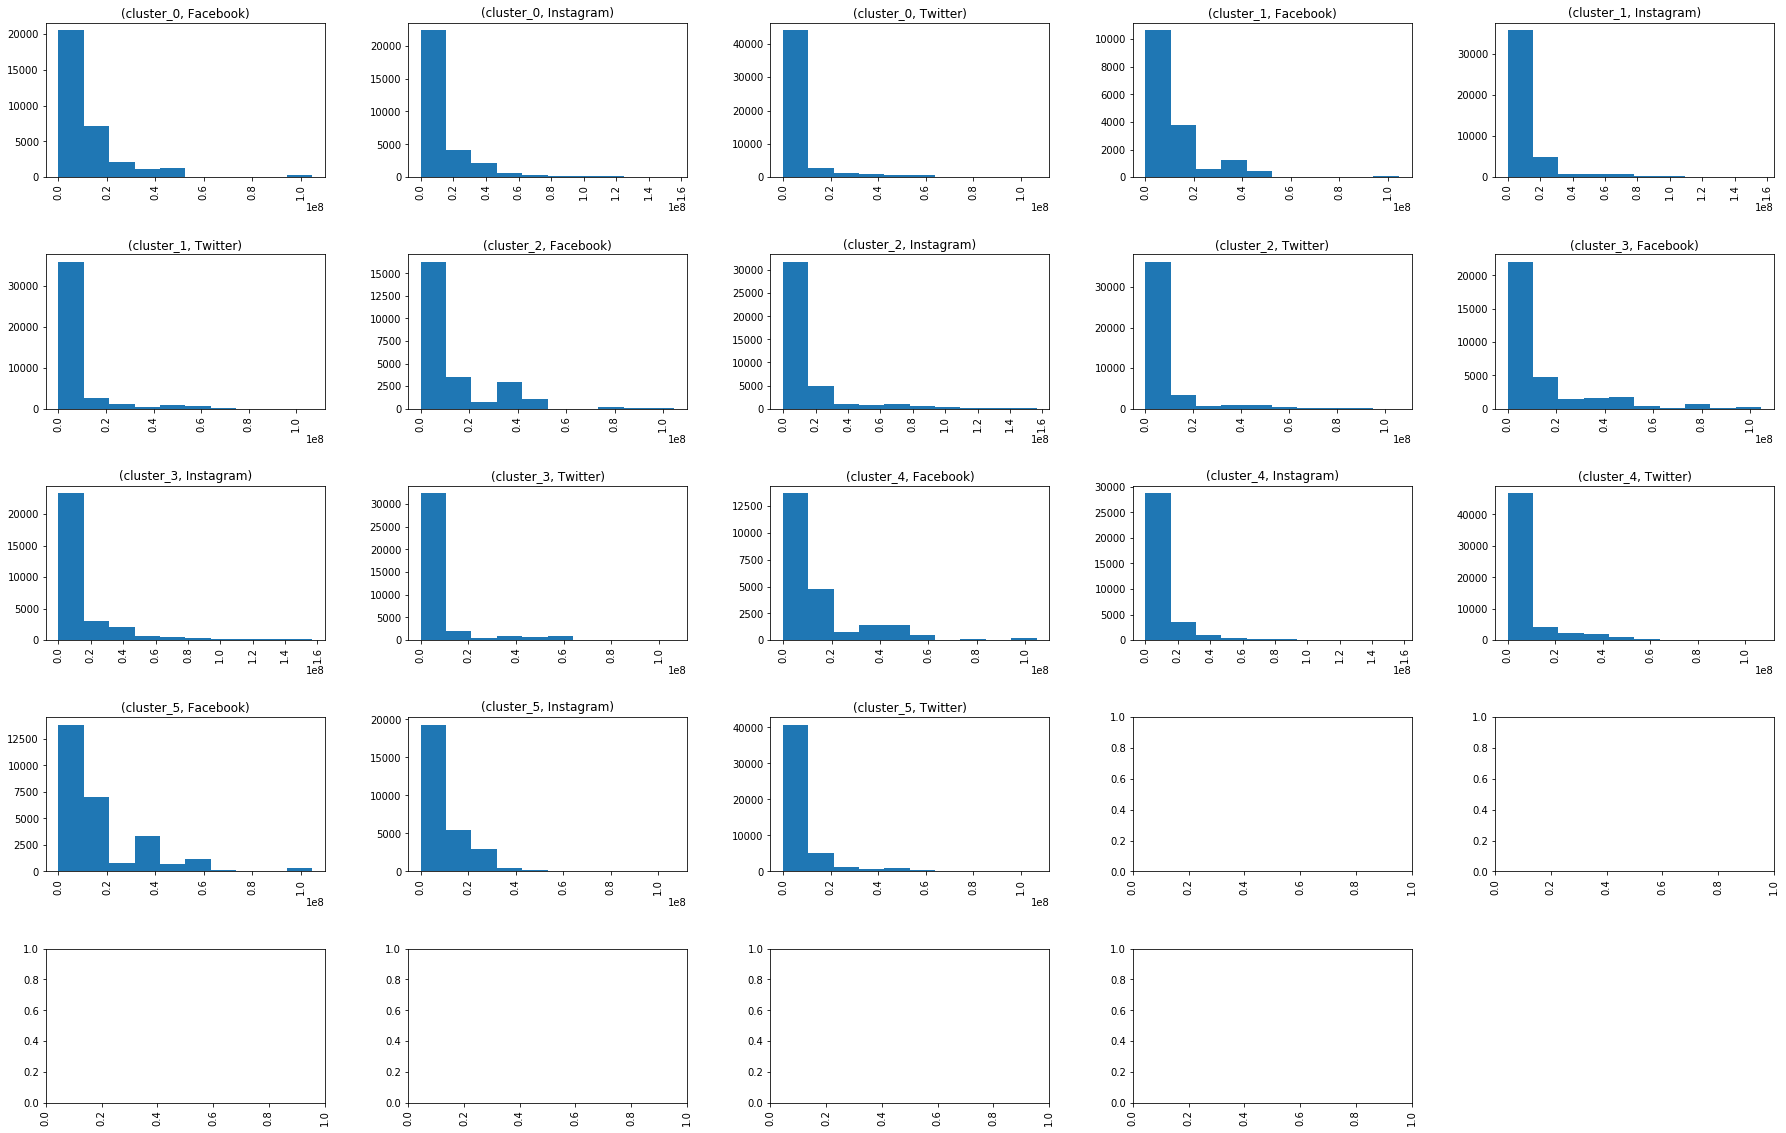

In [335]:
df_total['count_of_followers'].hist(by=[df_total['cluster'],df_total['social_platform']], figsize=(30,20))
plt.show()

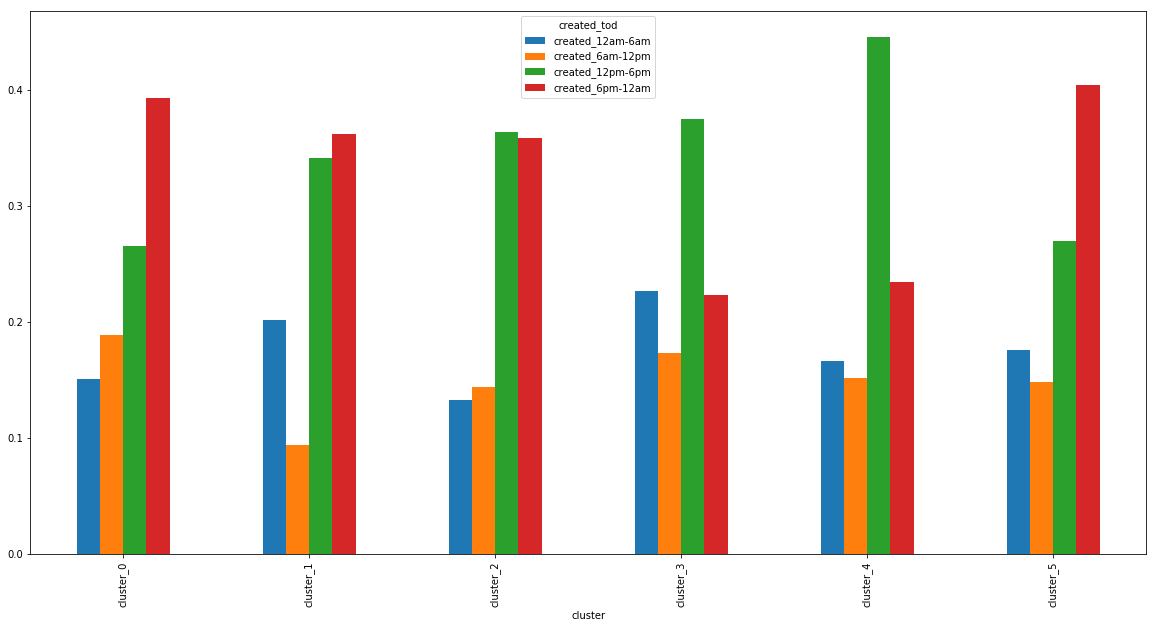

In [440]:
temp = pd.crosstab(df_total['cluster'],df_total['created_tod'], normalize='index')
temp = temp[['created_12am-6am','created_6am-12pm','created_12pm-6pm','created_6pm-12am']]
temp.plot(kind='bar', figsize=(20,10))
plt.show()

In [310]:
genres = ['genre_electronic_x', 'genre_hip_hop_x', 'genre_pop_x',
       'genre_r_and_b_x', 'genre_rock_x', 'genre_world_music_x']

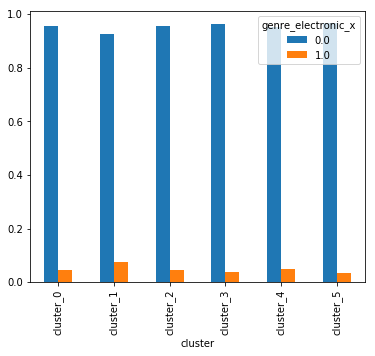

In [348]:
pd.crosstab(df_total['cluster'],df_total[genres[0]], normalize='index').plot(kind='bar', figsize=(6,5))
plt.show()

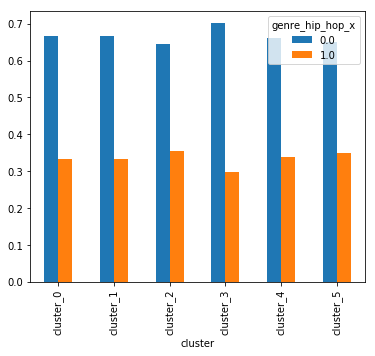

In [349]:
pd.crosstab(df_total['cluster'],df_total[genres[1]], normalize='index').plot(kind='bar', figsize=(6,5))
plt.show()

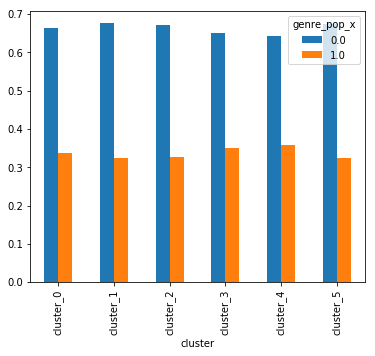

In [350]:
pd.crosstab(df_total['cluster'],df_total[genres[2]], normalize='index').plot(kind='bar', figsize=(6,5))
plt.show()

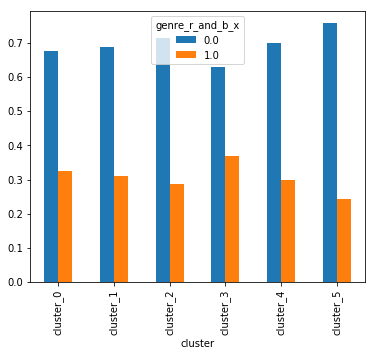

In [351]:
pd.crosstab(df_total['cluster'],df_total[genres[3]], normalize='index').plot(kind='bar', figsize=(6,5))
plt.show()

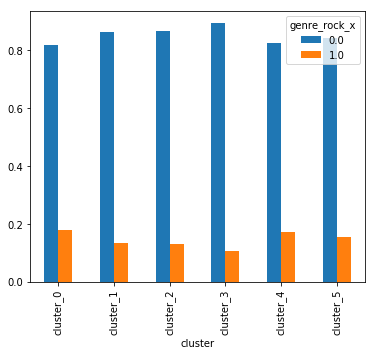

In [352]:
pd.crosstab(df_total['cluster'],df_total[genres[4]], normalize='index').plot(kind='bar', figsize=(6,5))
plt.show()

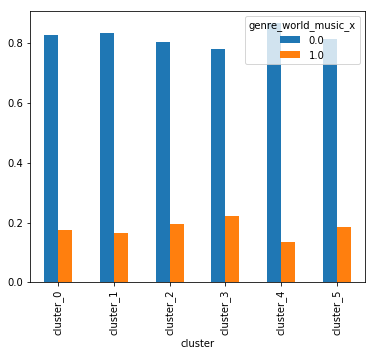

In [353]:
pd.crosstab(df_total['cluster'],df_total[genres[5]], normalize='index').plot(kind='bar', figsize=(6,5))
plt.show()

In [442]:
df_total.groupby('cluster')['description_length'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
cluster_0,"114,784.00",101.80,99.31,1.00,39.00,82.00,136.00,999.00
cluster_1,"102,621.00",103.35,102.88,1.00,41.00,83.00,136.00,999.00
cluster_2,"109,136.00",95.56,100.47,1.00,34.00,74.00,129.00,999.00
cluster_3,"101,302.00",103.90,106.97,1.00,38.00,82.00,135.00,"1,000.00"
cluster_4,"115,023.00",101.42,100.06,1.00,39.00,81.00,135.00,"1,000.00"
cluster_5,"106,020.00",102.56,108.40,1.00,35.00,80.00,135.00,"1,000.00"


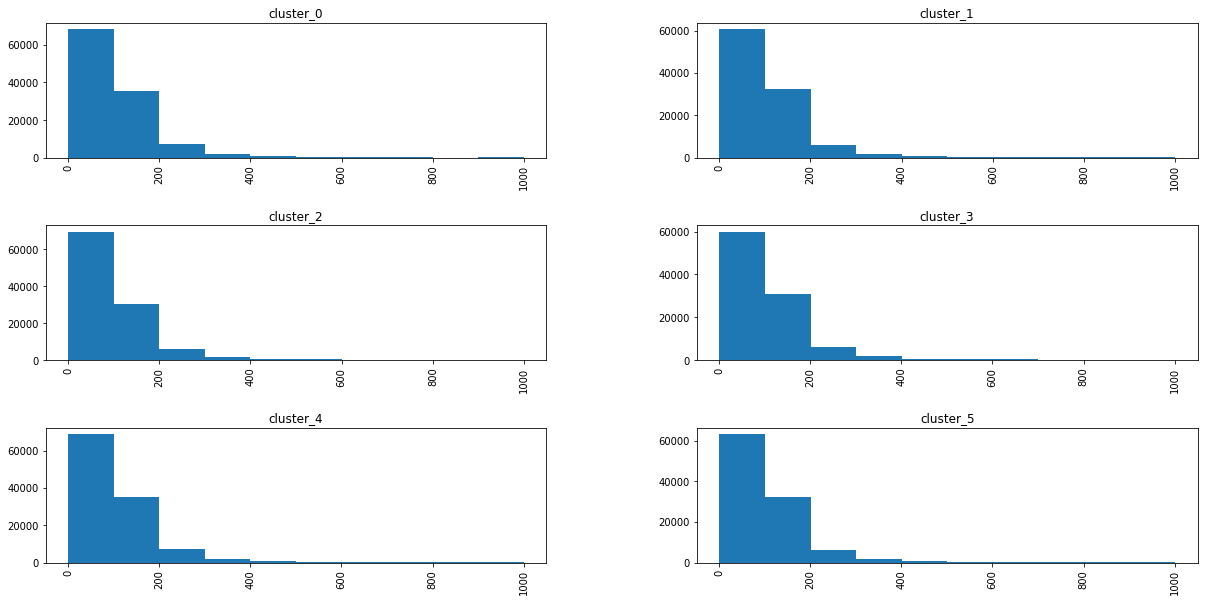

In [337]:
df_total['description_length'].hist(by=df_total['cluster'], figsize=(20,10))
plt.show()

In [443]:
df_total.groupby('cluster')['hashtag_count'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
cluster_0,"114,784.00",0.68,1.31,0.00,0.00,0.00,1.00,31.00
cluster_1,"102,621.00",0.76,1.40,0.00,0.00,0.00,1.00,52.00
cluster_2,"109,136.00",0.68,1.32,0.00,0.00,0.00,1.00,30.00
cluster_3,"101,302.00",0.76,1.45,0.00,0.00,0.00,1.00,32.00
cluster_4,"115,023.00",0.79,1.62,0.00,0.00,0.00,1.00,32.00
cluster_5,"106,020.00",0.85,1.71,0.00,0.00,0.00,1.00,32.00


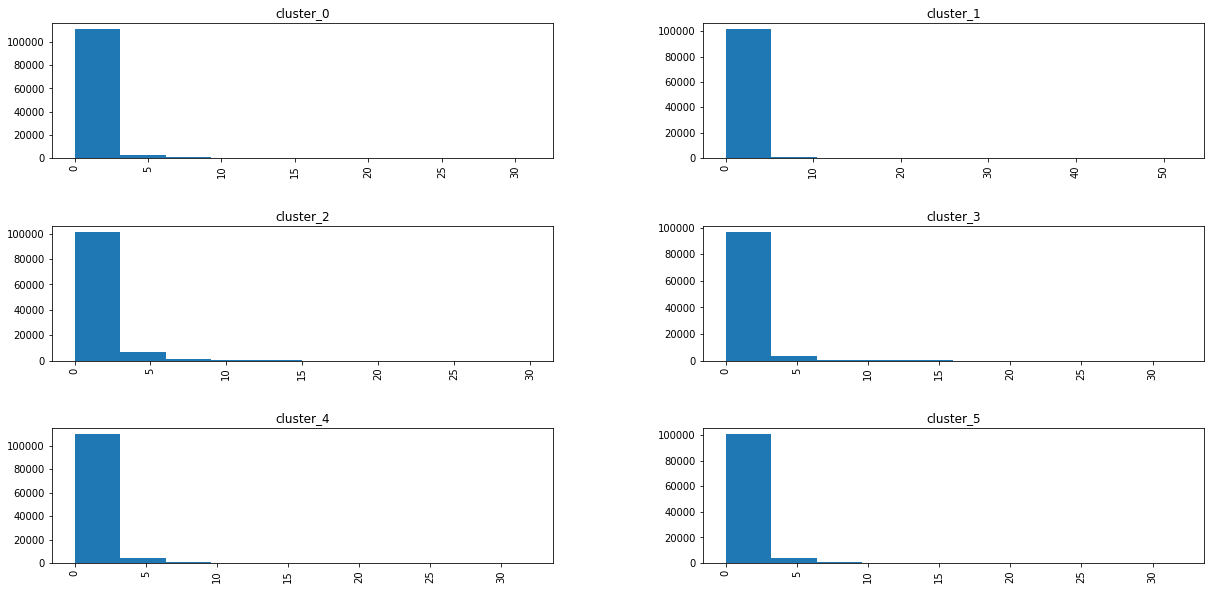

In [338]:
df_total['hashtag_count'].hist(by=df_total['cluster'], figsize=(20,10))
plt.show()

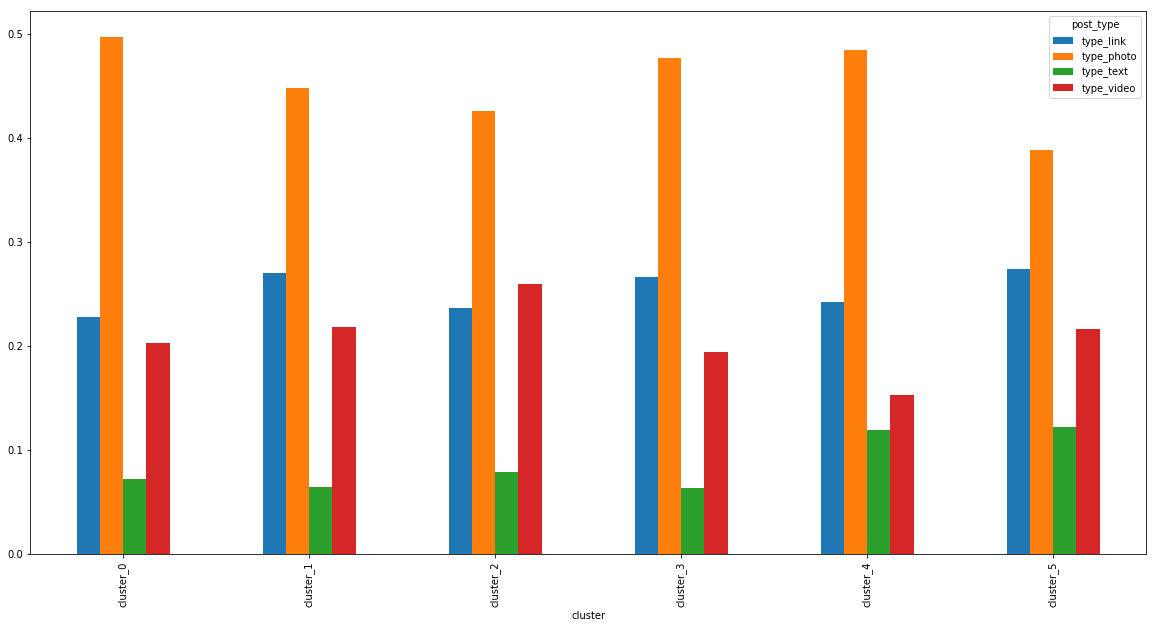

In [354]:
pd.crosstab(df_total['cluster'],df_total['post_type'], normalize='index').plot(kind='bar', figsize=(20,10))
plt.show()

In [445]:
df_total.groupby('cluster')['num_days_to_track_release'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
cluster_0,"114,784.00",80.65,177.67,0.00,7.00,23.00,79.00,"3,064.00"
cluster_1,"102,621.00",86.17,176.38,0.00,7.00,25.00,88.00,"3,061.00"
cluster_2,"109,136.00",96.15,207.55,0.00,7.00,24.00,87.00,"3,064.00"
cluster_3,"101,302.00",71.31,145.59,0.00,6.00,21.00,71.00,"3,042.00"
cluster_4,"115,023.00",85.89,179.07,0.00,8.00,27.00,85.00,"3,064.00"
cluster_5,"106,020.00",99.89,209.90,0.00,7.00,25.00,89.00,"3,060.00"


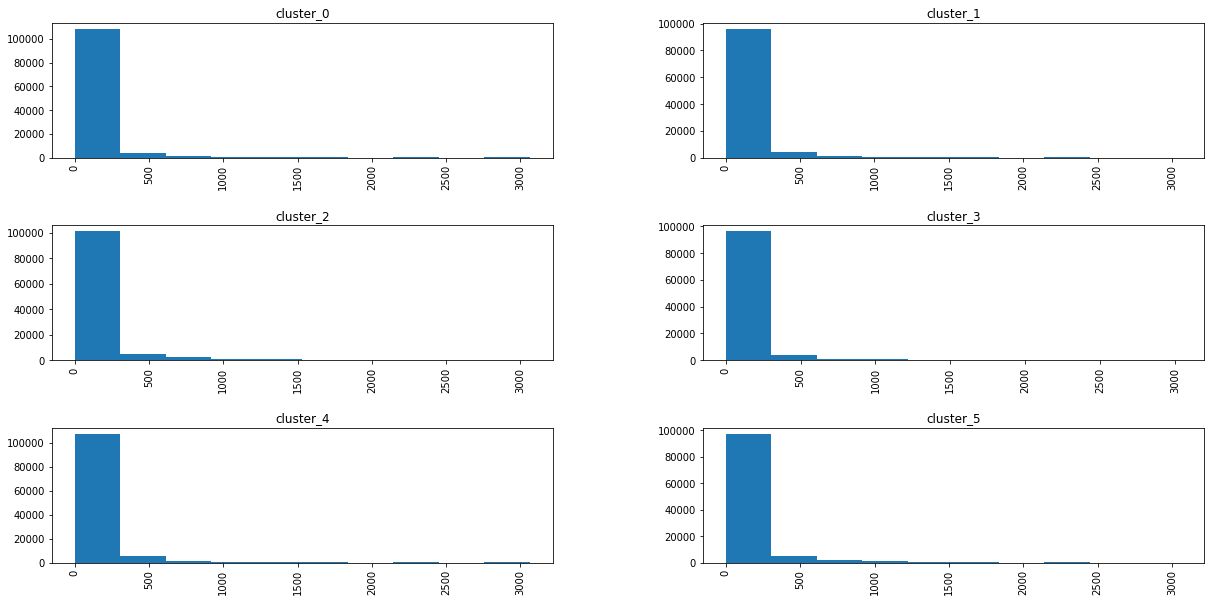

In [339]:
df_total['num_days_to_track_release'].hist(by=df_total['cluster'], figsize=(20,10))
plt.show()

In [448]:
df_total[df_total['time_since_last_post']<200000].groupby(
    'cluster')['time_since_last_post'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
cluster_0,"108,318.00","32,041.72","42,317.95",0.00,"1,794.00","11,703.50","52,799.00","199,947.00"
cluster_1,"95,170.00","35,998.83","46,248.46",0.00,"1,782.00","12,606.00","63,245.50","199,968.00"
cluster_2,"102,905.00","32,619.37","43,565.84",0.00,"1,336.00","10,815.00","54,248.00","199,979.00"
cluster_3,"95,479.00","34,081.13","43,017.62",0.00,"1,792.50","13,501.00","56,967.00","199,981.00"
cluster_4,"107,570.00","35,684.89","44,167.56",0.00,"2,128.00","14,412.50","60,523.00","199,971.00"
cluster_5,"99,760.00","32,145.40","43,592.28",0.00,"1,404.00","10,567.00","53,928.25","199,987.00"


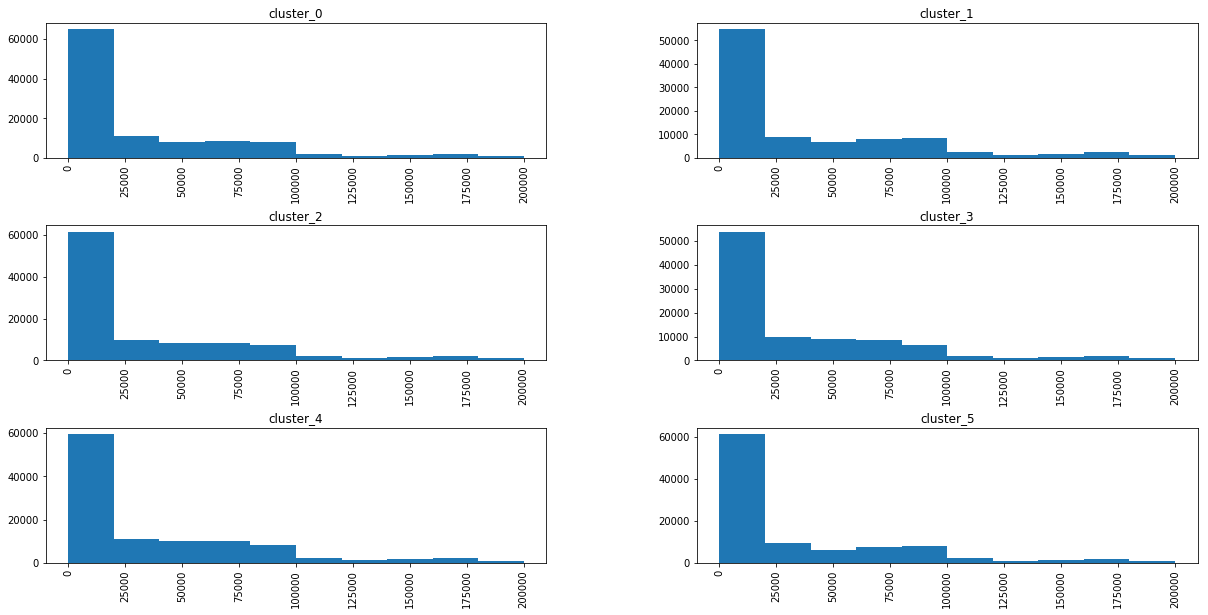

In [344]:
df_total[df_total['time_since_last_post']<200000]['time_since_last_post'].hist(
    by=df_total[df_total['time_since_last_post']<200000]['cluster'], figsize=(20,10))
plt.show()

In [368]:
print(df_total.shape)
print(df_total_dropnan.shape)

(648886, 45)
(628752, 45)


In [380]:
correlation_features = ['Facebook', 'Instagram', 'Twitter', 'Youtube', 'age_x',
       'count_of_followers', 'created_12am-6am',
       'created_12pm-6pm', 'created_6am-12pm', 'created_6pm-12am','description_length', 
       'genre_electronic_x', 'genre_hip_hop_x', 'genre_pop_x',
       'genre_r_and_b_x', 'genre_rock_x', 'genre_world_music_x',
       'hashtag_count', 'last_30_days', 'last_7_days',
       'social_engagement_score', 'time_since_last_post',
       'type_link', 'type_photo', 'type_text', 'type_video',
       'within_month_release', 'within_week_release', 'years_active_x',
       'normalized_social_engagement_score','num_days_to_track_release']

In [414]:
for c in set(df_total['cluster']):
    print("Cluster: " + c)
    print(df_total[df_total['cluster']==c][correlation_features].corr()['social_engagement_score'])

Cluster: cluster_4
Facebook                             -0.155
Instagram                             0.470
Twitter                              -0.308
Youtube                                 nan
age_x                                -0.162
count_of_followers                   -0.102
created_12am-6am                     -0.097
created_12pm-6pm                      0.140
created_6am-12pm                     -0.000
created_6pm-12am                     -0.079
description_length                   -0.076
genre_electronic_x                    0.050
genre_hip_hop_x                      -0.024
genre_pop_x                           0.054
genre_r_and_b_x                      -0.046
genre_rock_x                          0.148
genre_world_music_x                  -0.117
hashtag_count                        -0.036
last_30_days                         -0.128
last_7_days                          -0.127
social_engagement_score               1.000
time_since_last_post                  0.070
type_link    

In [452]:
for c in set(df_total['cluster']):
    print("Cluster: " + c)
    print(df_total[df_total['cluster']==c][['Facebook', 'Instagram', 'Twitter','social_engagement_score']].corr()['social_engagement_score'])

Cluster: cluster_4
Facebook                  -0.16
Instagram                  0.47
Twitter                   -0.31
social_engagement_score    1.00
Name: social_engagement_score, dtype: float64
Cluster: cluster_3
Facebook                  -0.17
Instagram                  0.40
Twitter                   -0.22
social_engagement_score    1.00
Name: social_engagement_score, dtype: float64
Cluster: cluster_0
Facebook                  -0.13
Instagram                  0.32
Twitter                   -0.16
social_engagement_score    1.00
Name: social_engagement_score, dtype: float64
Cluster: cluster_5
Facebook                  -0.10
Instagram                  0.32
Twitter                   -0.19
social_engagement_score    1.00
Name: social_engagement_score, dtype: float64
Cluster: cluster_1
Facebook                  -0.15
Instagram                  0.44
Twitter                   -0.33
social_engagement_score    1.00
Name: social_engagement_score, dtype: float64
Cluster: cluster_2
Facebook        

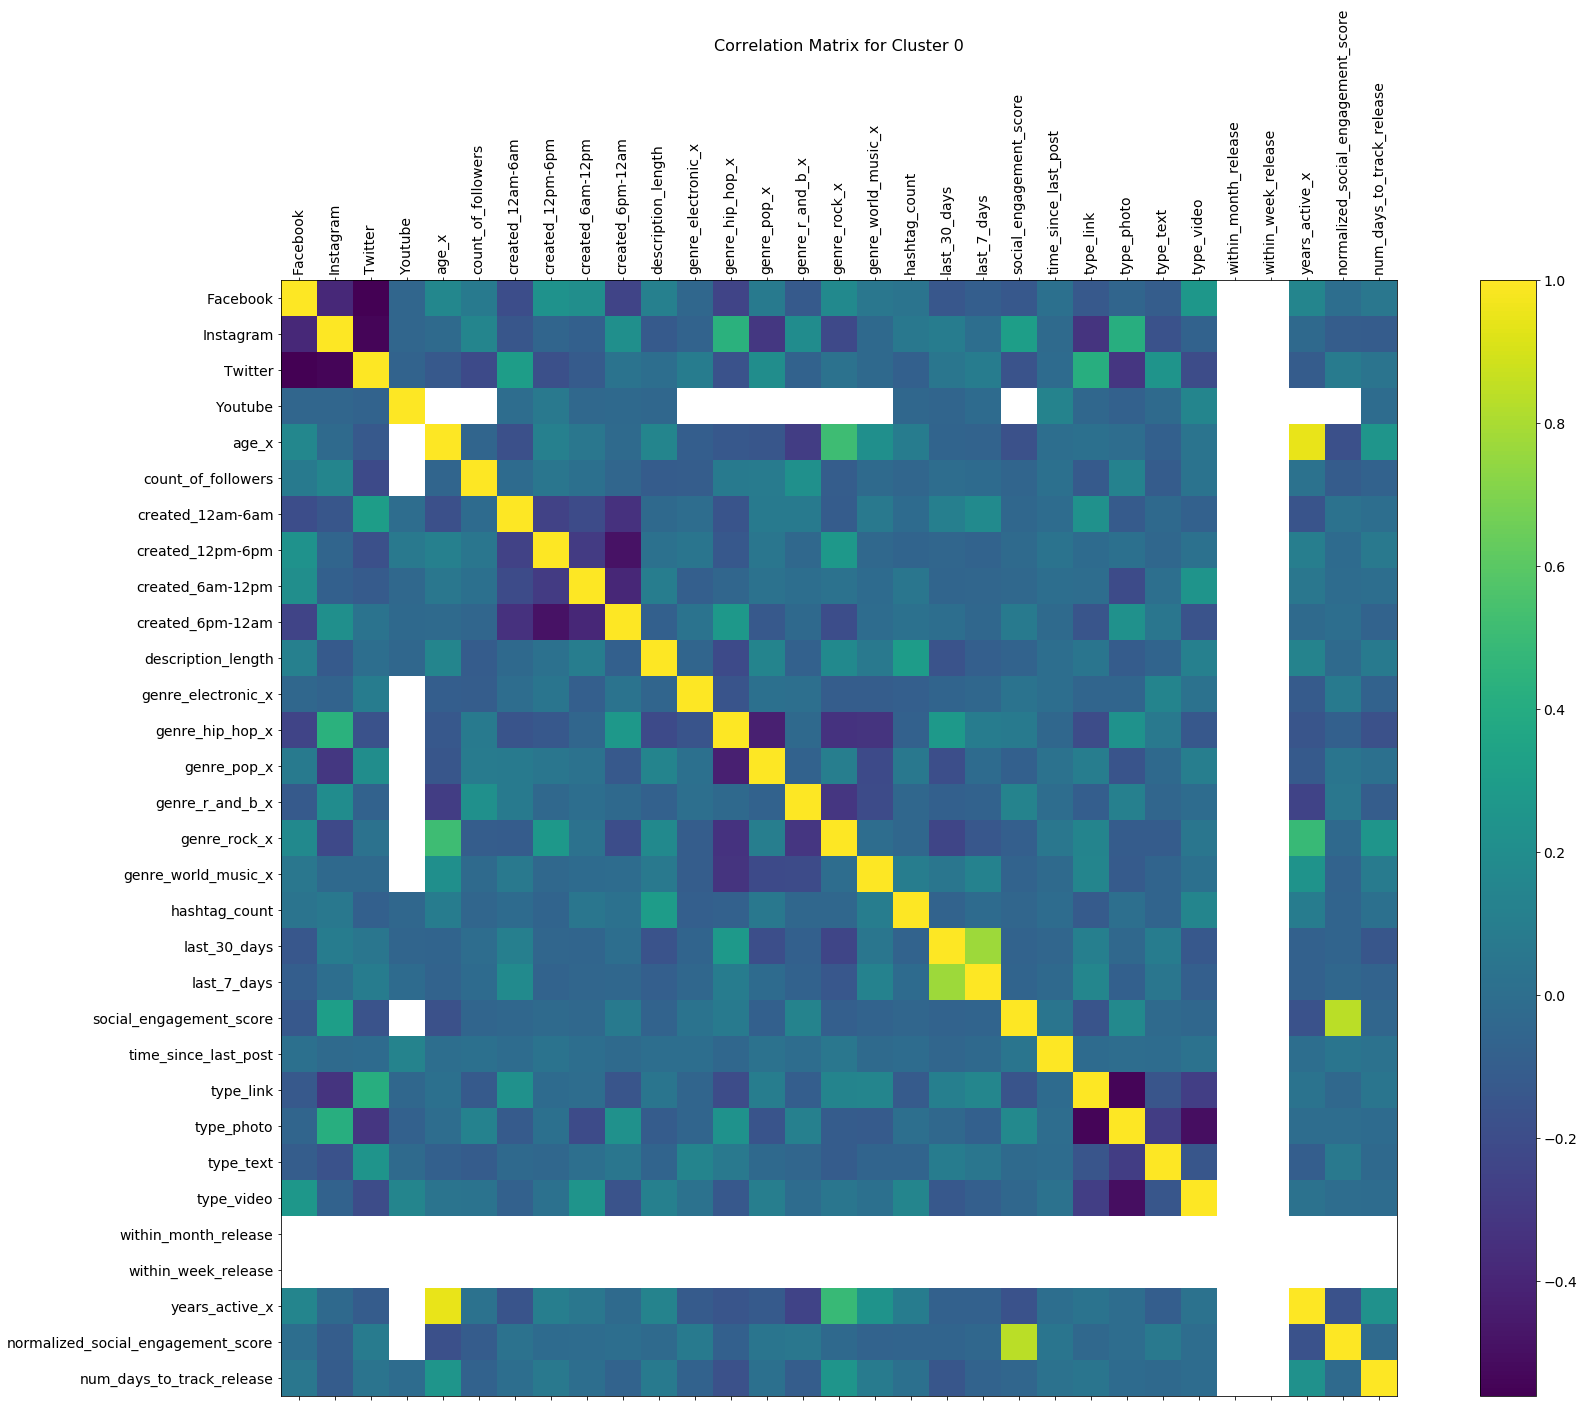

In [401]:
temp = df_total[df_total['cluster']=='cluster_0'][correlation_features]
fig = plt.figure(figsize=(30,20))
plt.matshow(temp.corr(),fignum=fig.number)
plt.xticks(range(temp.shape[1]), temp.columns, fontsize=14, rotation=90)
plt.yticks(range(temp.shape[1]), temp.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for Cluster 0', fontsize=16, y = 1.2);
plt.show()

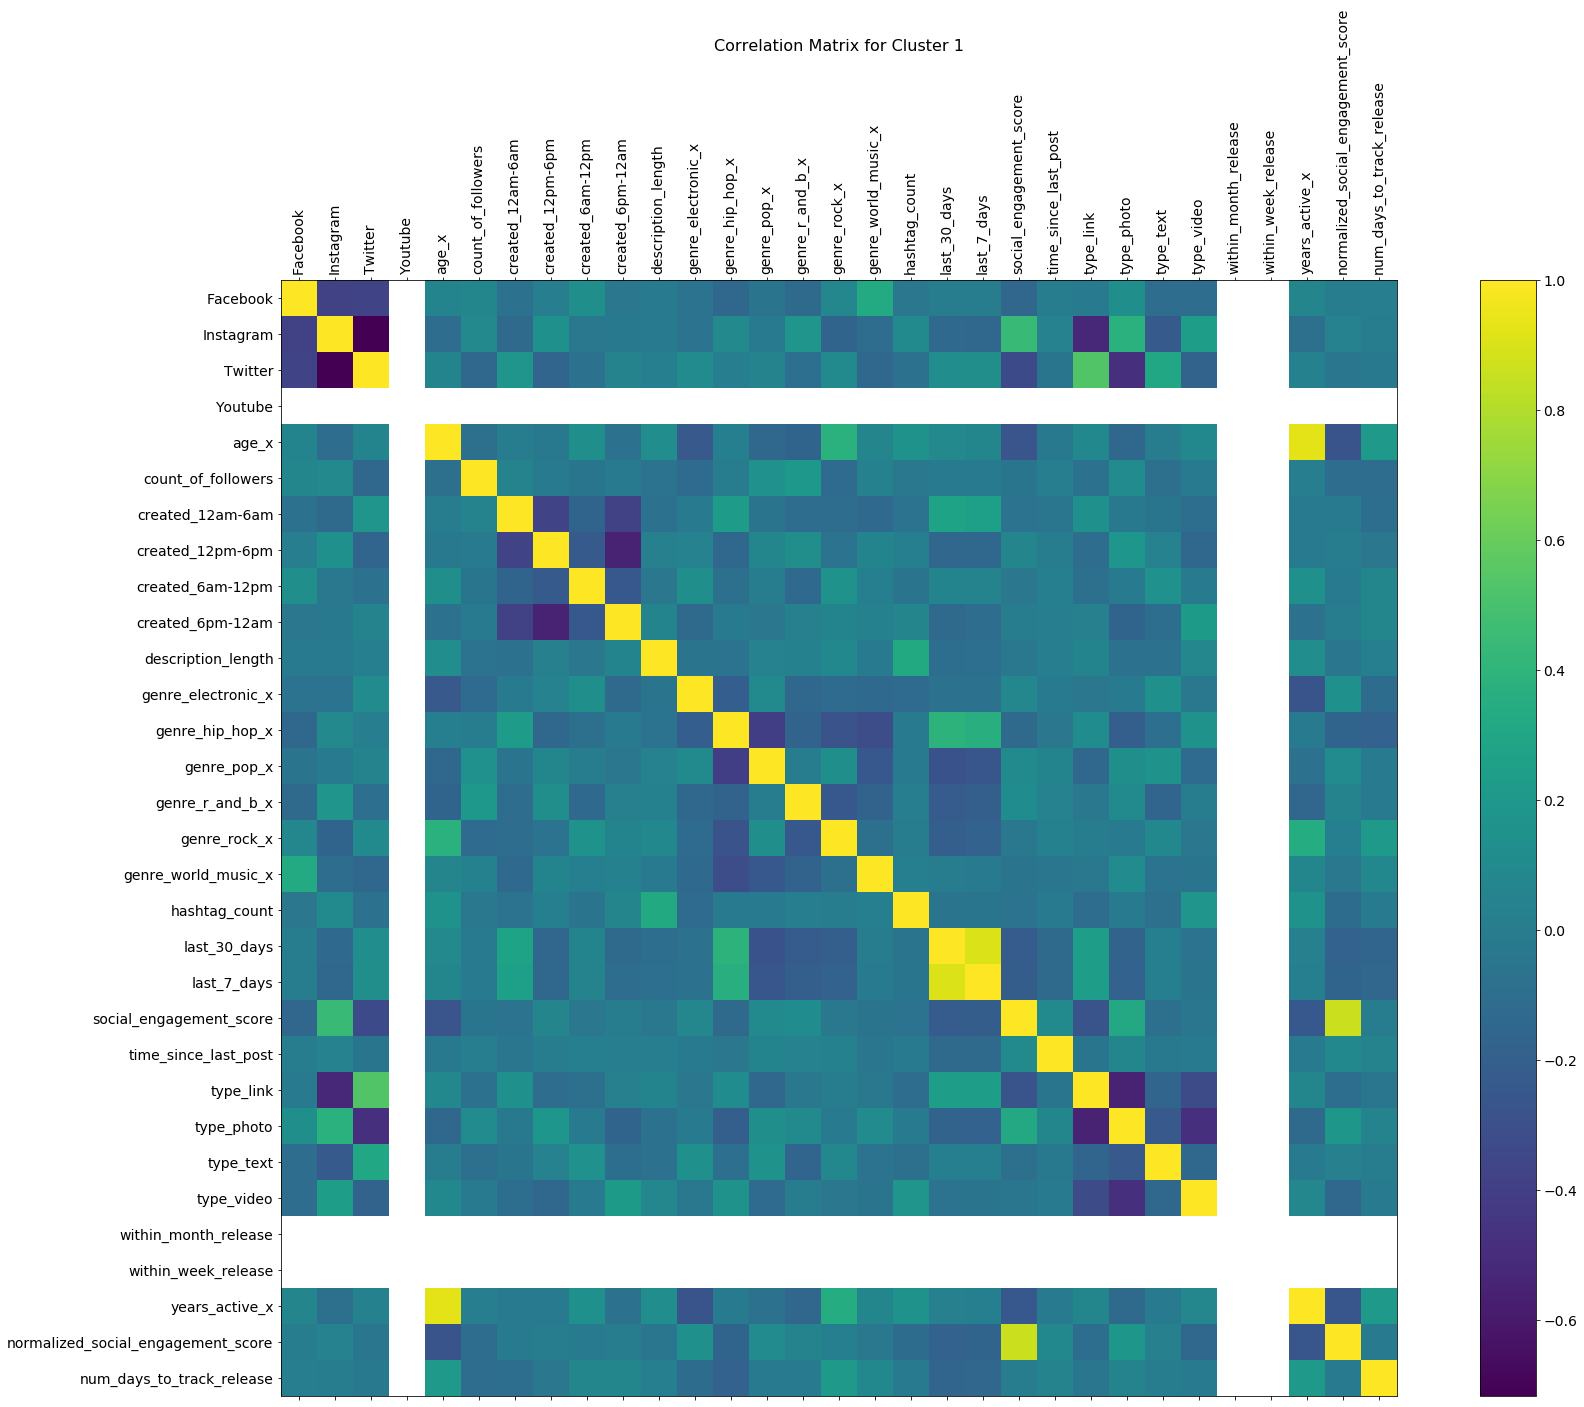

In [402]:
temp = df_total[df_total['cluster']=='cluster_1'][correlation_features]
fig = plt.figure(figsize=(30,20))
plt.matshow(temp.corr(),fignum=fig.number)
plt.xticks(range(temp.shape[1]), temp.columns, fontsize=14, rotation=90)
plt.yticks(range(temp.shape[1]), temp.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for Cluster 1', fontsize=16, y = 1.2);
plt.show()

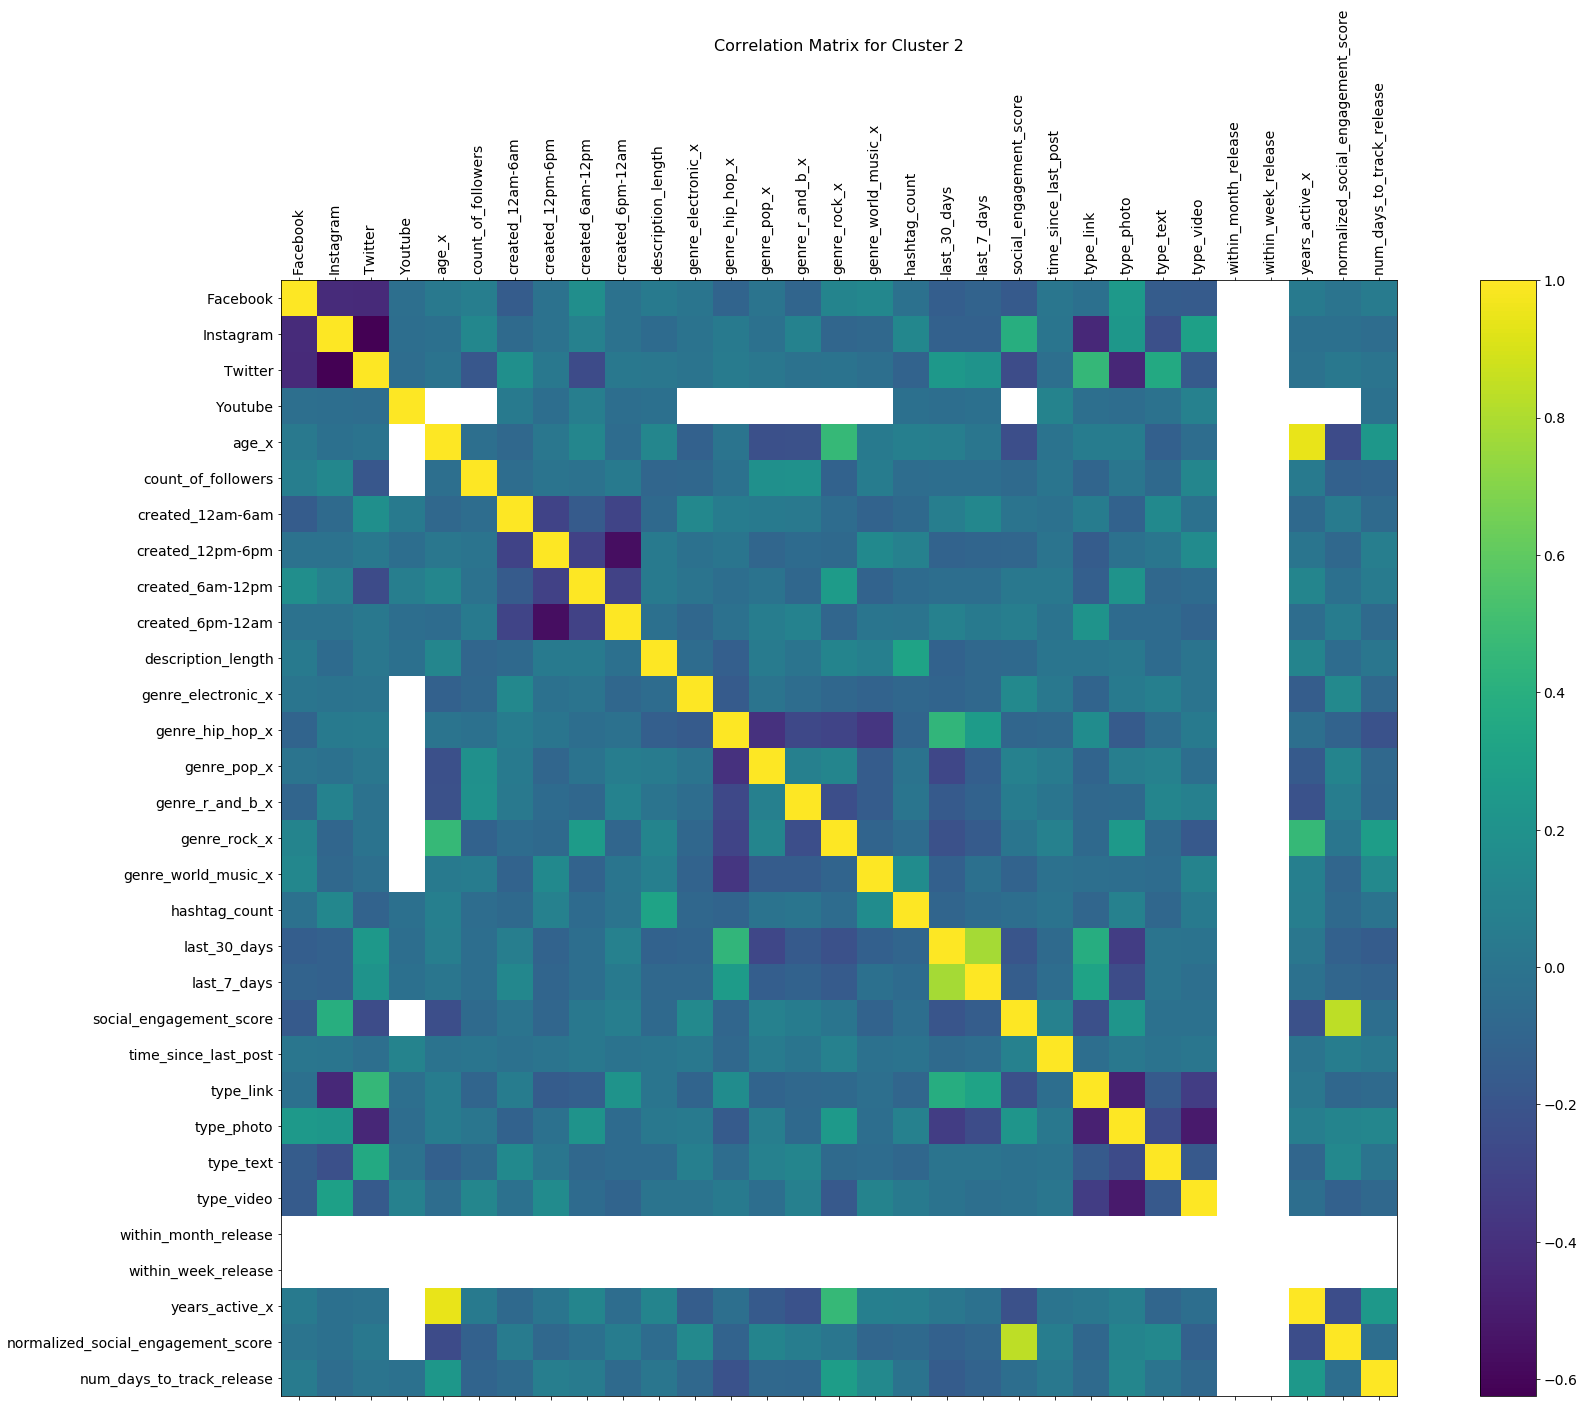

In [403]:
temp = df_total[df_total['cluster']=='cluster_2'][correlation_features]
fig = plt.figure(figsize=(30,20))
plt.matshow(temp.corr(),fignum=fig.number)
plt.xticks(range(temp.shape[1]), temp.columns, fontsize=14, rotation=90)
plt.yticks(range(temp.shape[1]), temp.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for Cluster 2', fontsize=16, y = 1.2);
plt.show()

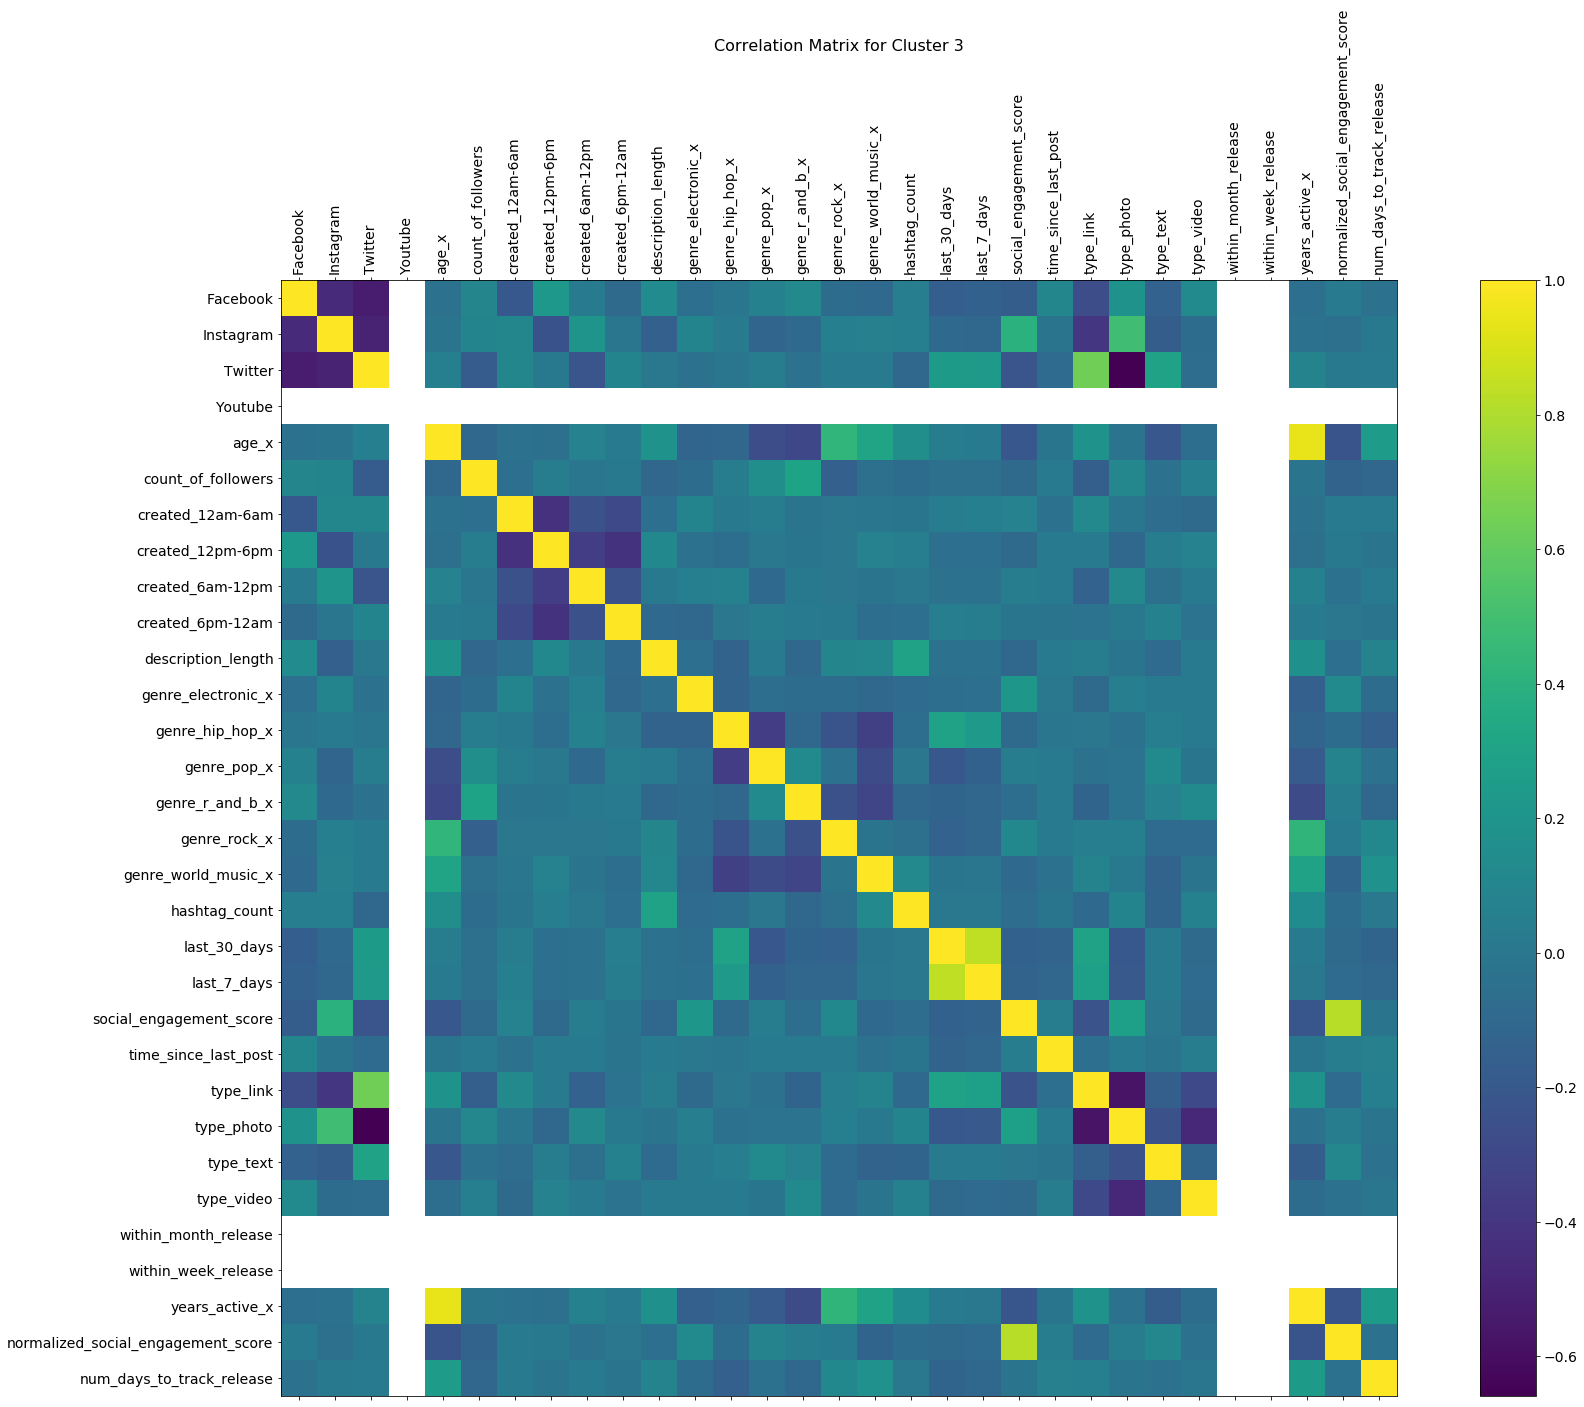

In [404]:
temp = df_total[df_total['cluster']=='cluster_3'][correlation_features]
fig = plt.figure(figsize=(30,20))
plt.matshow(temp.corr(),fignum=fig.number)
plt.xticks(range(temp.shape[1]), temp.columns, fontsize=14, rotation=90)
plt.yticks(range(temp.shape[1]), temp.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for Cluster 3', fontsize=16, y = 1.2);
plt.show()

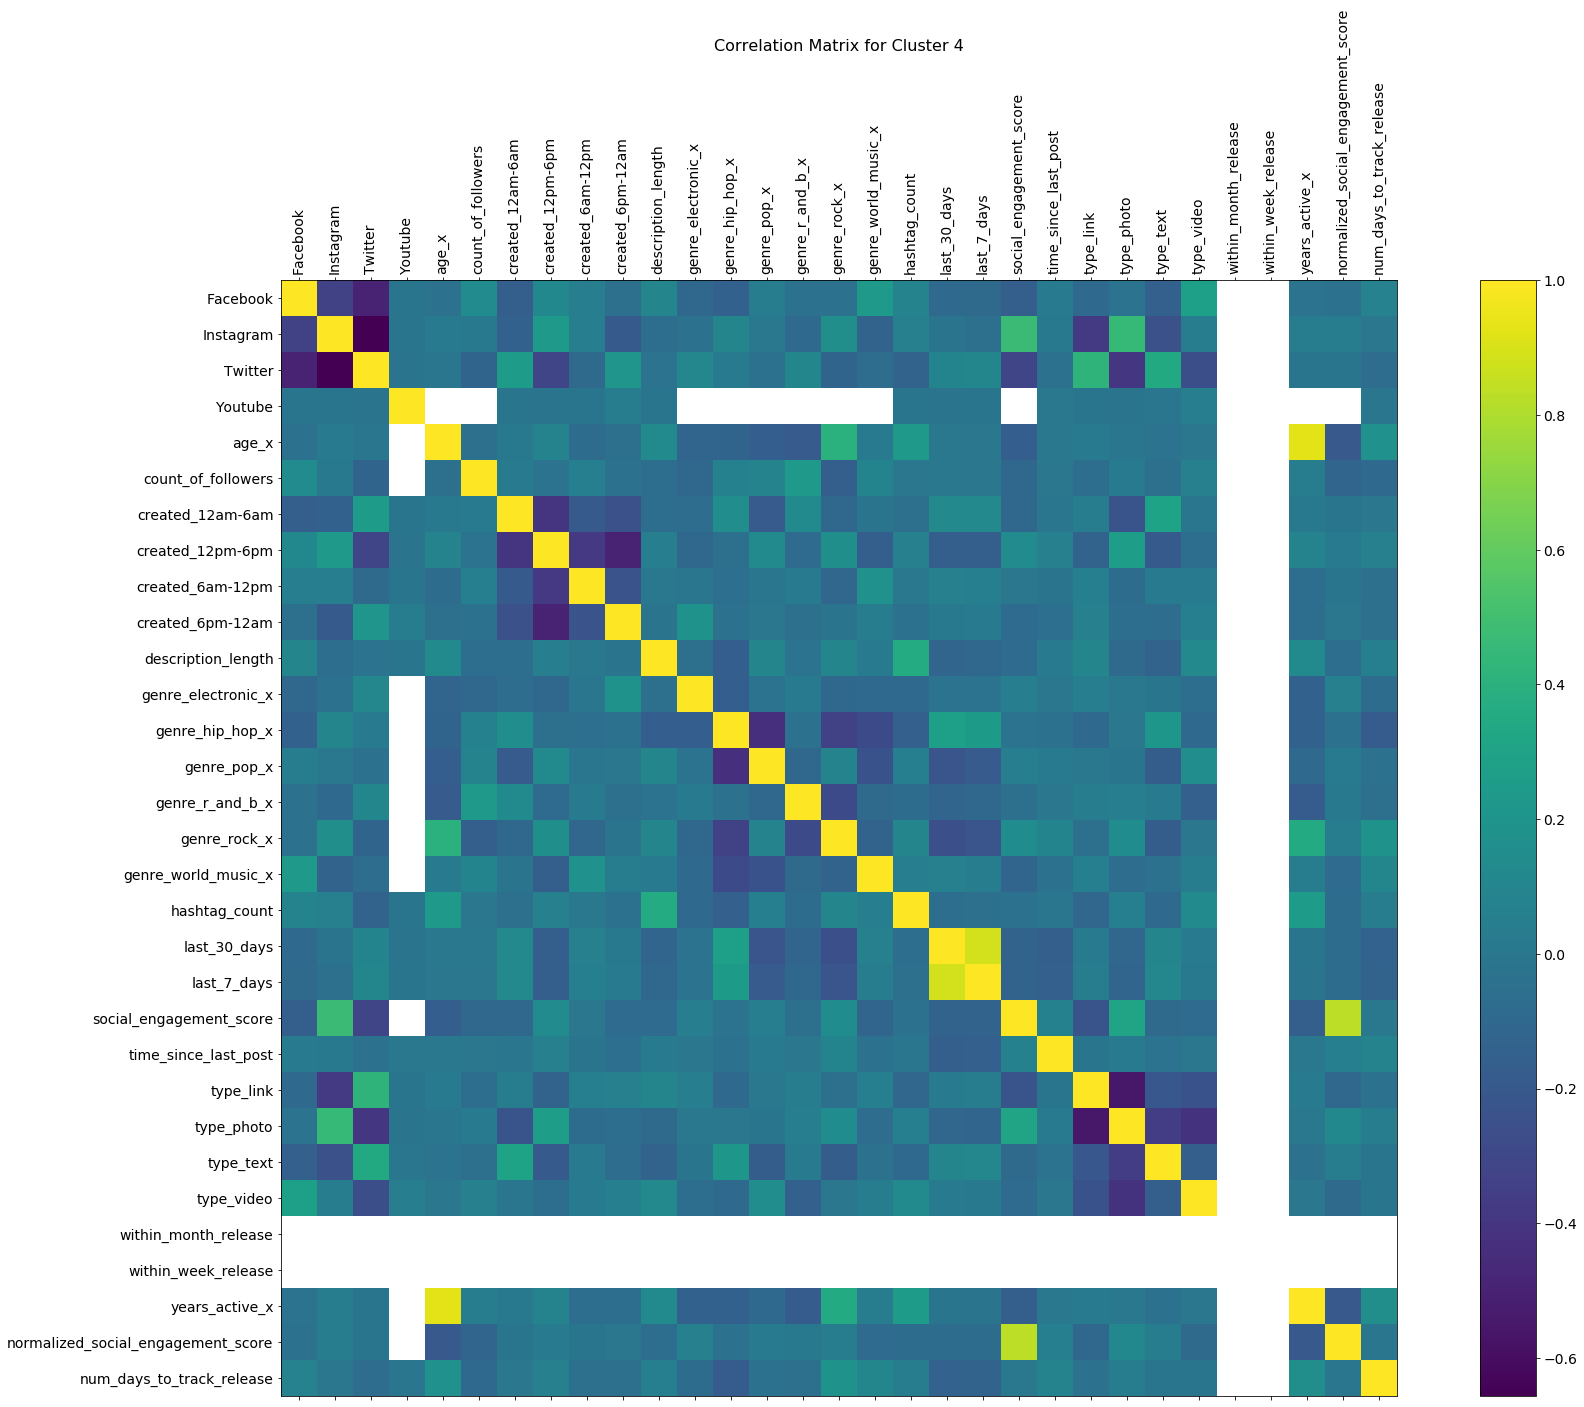

In [405]:
temp = df_total[df_total['cluster']=='cluster_4'][correlation_features]
fig = plt.figure(figsize=(30,20))
plt.matshow(temp.corr(),fignum=fig.number)
plt.xticks(range(temp.shape[1]), temp.columns, fontsize=14, rotation=90)
plt.yticks(range(temp.shape[1]), temp.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for Cluster 4', fontsize=16, y = 1.2);
plt.show()

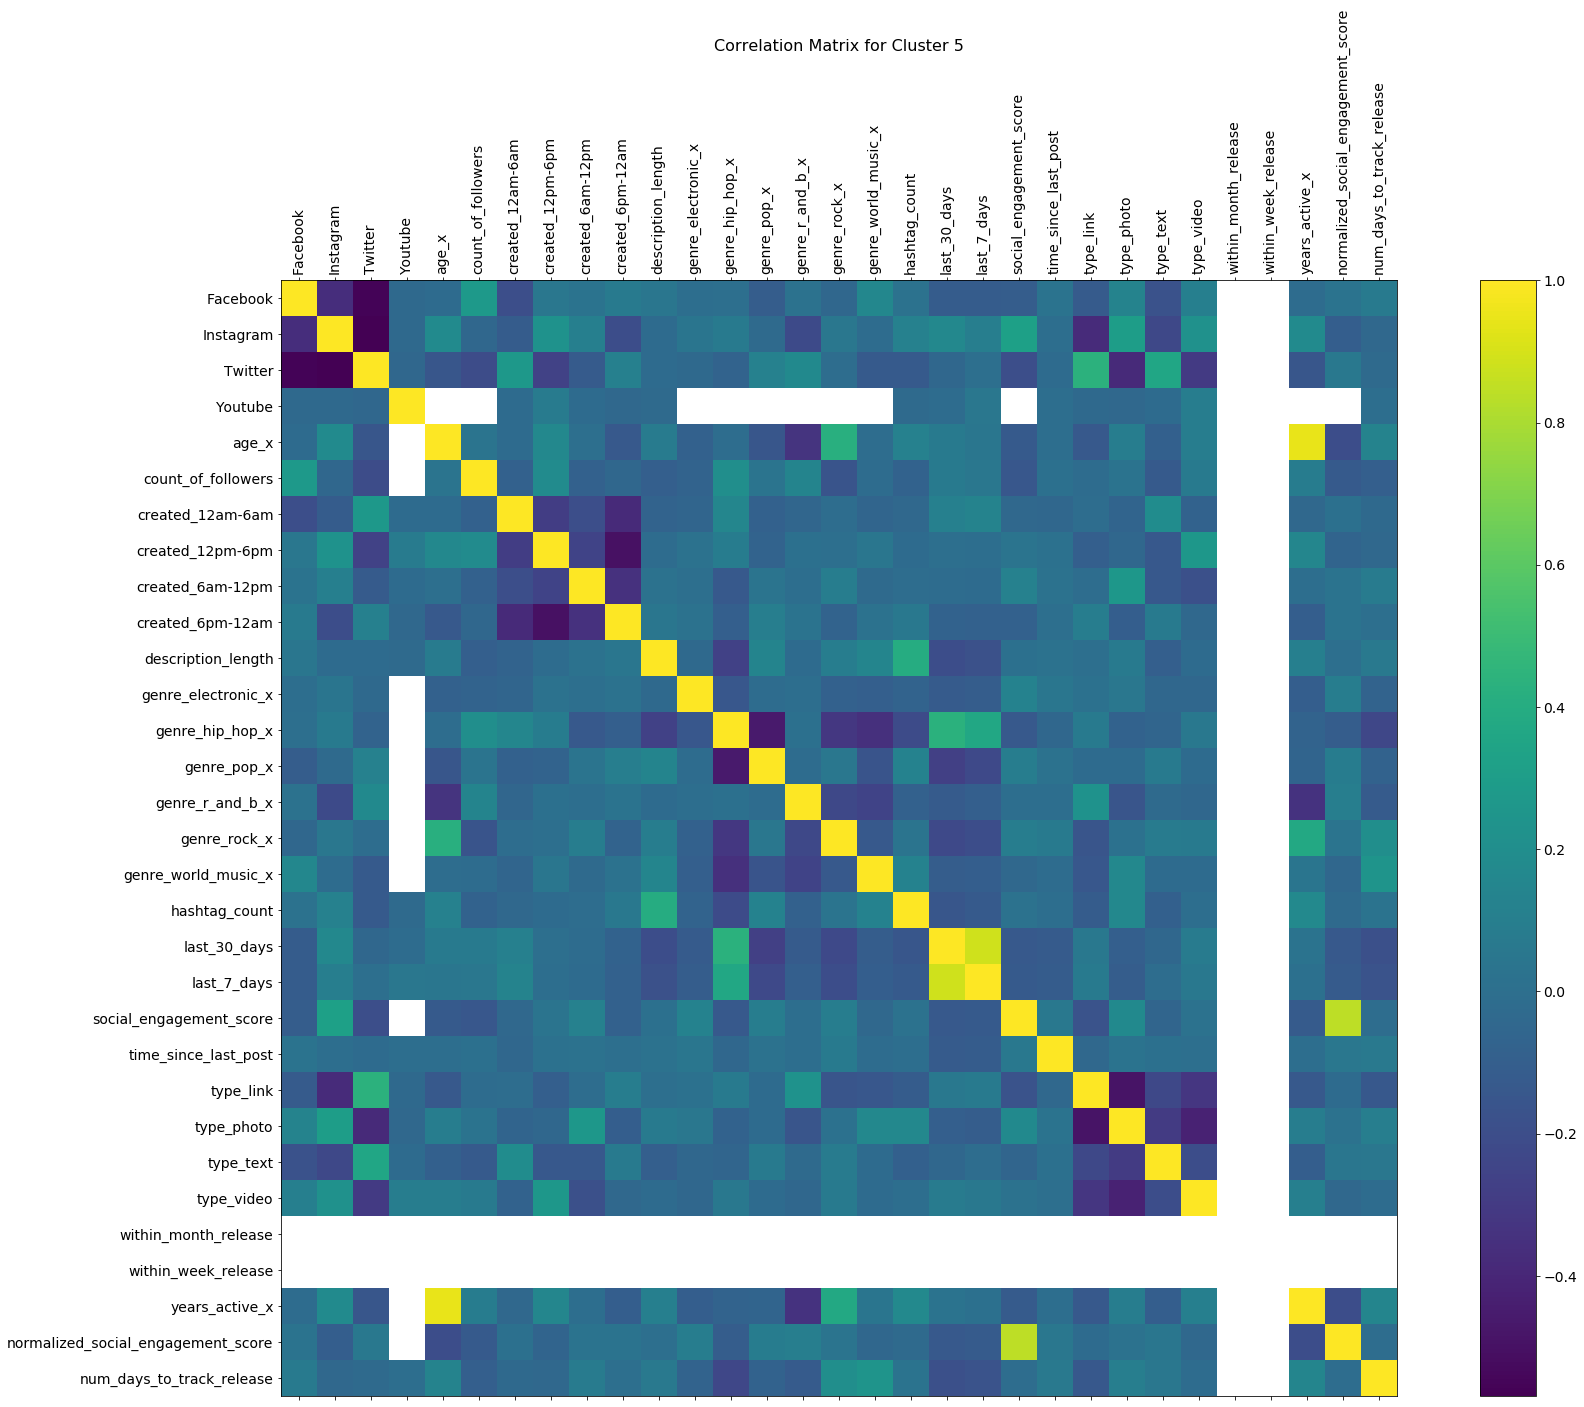

In [406]:
temp = df_total[df_total['cluster']=='cluster_5'][correlation_features]
fig = plt.figure(figsize=(30,20))
plt.matshow(temp.corr(),fignum=fig.number)
plt.xticks(range(temp.shape[1]), temp.columns, fontsize=14, rotation=90)
plt.yticks(range(temp.shape[1]), temp.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for Cluster 5', fontsize=16, y = 1.2);
plt.show()

def plotting(chart_type,column,data=df_total.groupby('cluster')):
    '''
    For plotting bar charts and histograms
    '''
    fig = plt.figure(figsize=(20,12))
    if chart_type=='bar':
        for title, group in data:
        sns.countplot(data[column],color='skyblue')
    if chart_type=='hist':
        sns.distplot(data[column],color='skyblue')
    else: return
    plt.show()
    